In [41]:
## Bibliotecas
import pandas as pd
import bokeh.plotting as bp
import sys
sys.path.append(r'C:\Users\giovanni.5683\GITHUB\controlling_postgreSQL')  # Adiciona o diretório onde está conn.py
from conn import get_connection
engine = get_connection()
cursor = engine.cursor()

In [42]:
query = """SELECT * FROM byd.bonus_view
ORDER BY dta_processamento DESC;"""
data = pd.read_sql(query, engine)
data.columns

C:\Users\giovanni.5683\AppData\Local\Temp\ipykernel_5252\3482232329.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



Index(['idnfsexterno', 'revenda', 'empresa', 'numero_nota_fiscal',
       'serie_nota_fiscal', 'dta_processamento', 'tipo_transacao',
       'des_tipo_transacao', 'cod_cliente', 'nome_cliente', 'cpf', 'cnpj',
       'fisico_juridico', 'vendedor', 'nome_vendedor', 'proposta', 'chassi',
       'placa', 'ano_fabricacao', 'ano_modelo', 'des_modelo', 'val_modalidade',
       'lucbru', 'bonus', 'val_icms', 'val_ipi', 'imposto_importacao',
       'val_pis', 'val_cofins', 'nota_origem_devolucao',
       'dta_nota_origem_devolucao', 'dta_compra', 'valor_venda_bruta',
       'val_custo_contabil', 'tipo_venda', 'ano_modelo_formatado',
       'dta_emplacamento', 'status_emplacamento', 'loja', 'dias_em_estoque',
       'apontamento', 'data_emissao_proposta', 'data_ajustada', 'valor_bonus',
       'rebate', 'reembolso_ipva', 'comissao_vd', 'trade', 'portal', 'varejo',
       'equalizacao', 'trade_in', 'taxa_0', 'ipva', 'wallbox', 'portatil',
       'seguro', 'refaturado', 'em_valid', 'opt_comecial',

In [43]:
from bokeh.models import ColumnDataSource, CustomJS

# Definir ordem dos meses
ordem_meses = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 
               'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']

# Criar figura com eixo X categórico
p = bp.figure(title="Dispersão de Bônus por Competência e Revenda",
              width=1000, height=600,
              x_range=ordem_meses,
              toolbar_location="above")

# Mapear meses para valores numéricos
mes_to_num = {mes: i for i, mes in enumerate(ordem_meses)}

# Armazenar os renderers dos círculos
circle_renderers = []

# Criar scatter plot para cada revenda
for idx, rev in enumerate(revendas):
    df_revenda = data_grouped[data_grouped['revenda'] == rev]
    df_revenda = df_revenda.copy()
    df_revenda['competencia_num'] = df_revenda['competencia'].map(mes_to_num)
    
    source = ColumnDataSource(df_revenda)
    
    renderer = p.circle(x='competencia', 
                       y='bonus_numeric',
                       size=10,
                       color=colors[idx],
                       alpha=0.6,
                       legend_label=f"Revenda {rev}",
                       source=source)
    circle_renderers.append(renderer)

# Criar fonte de dados para linha de tendência
x_trend = list(range(len(ordem_meses)))
y_trend = [0] * len(ordem_meses)  # Será atualizado pelo callback
trend_source = ColumnDataSource(data=dict(x=ordem_meses, y=y_trend))

# Adicionar linha de tendência
trend_line_renderer = p.line('x', 'y', 
                             source=trend_source,
                             line_width=2, 
                             color='red', 
                             alpha=0.8,
                             legend_label='Tendência Linear',
                             line_dash='dashed')

# Criar callback JavaScript para atualizar linha de tendência
callback = CustomJS(args=dict(renderers=circle_renderers, 
                             trend_source=trend_source,
                             mes_to_num=mes_to_num), code="""
    var x_all = [];
    var y_all = [];
    
    // Coletar dados visíveis
    for (var i = 0; i < renderers.length; i++) {
        if (renderers[i].visible) {
            var data = renderers[i].data_source.data;
            var comp = data['competencia'];
            var bonus = data['bonus_numeric'];
            
            for (var j = 0; j < comp.length; j++) {
                x_all.push(mes_to_num[comp[j]]);
                y_all.push(bonus[j]);
            }
        }
    }
    
    // Calcular regressão linear
    if (x_all.length > 0) {
        var n = x_all.length;
        var sum_x = 0, sum_y = 0, sum_xy = 0, sum_xx = 0;
        
        for (var i = 0; i < n; i++) {
            sum_x += x_all[i];
            sum_y += y_all[i];
            sum_xy += x_all[i] * y_all[i];
            sum_xx += x_all[i] * x_all[i];
        }
        
        var slope = (n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x);
        var intercept = (sum_y - slope * sum_x) / n;
        
        // Atualizar linha de tendência
        var new_y = [];
        for (var i = 0; i < 12; i++) {
            new_y.push(slope * i + intercept);
        }
        trend_source.data['y'] = new_y;
    } else {
        trend_source.data['y'] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0];
    }
    
    trend_source.change.emit();
""")

# Adicionar callback aos renderers
for renderer in circle_renderers:
    renderer.js_on_change('visible', callback)

# Adicionar HoverTool
hover = HoverTool(tooltips=[
    ("Competência", "@competencia"),
    ("Bônus", "@bonus_numeric{0,0.00}"),
    ("Revenda", "@revenda")
])
p.add_tools(hover)

# Configurar eixos e legenda
p.xaxis.axis_label = "Competência"
p.yaxis.axis_label = "Valor do Bônus (R$)"
p.xaxis.major_label_orientation = 45
p.legend.location = "top_right"
p.legend.click_policy = "hide"

# Calcular tendência inicial
x_numeric = data_grouped['competencia'].map(mes_to_num).values
y_values = data_grouped['bonus_numeric'].values
coef = np.polyfit(x_numeric, y_values, 1)
initial_trend = np.poly1d(coef)
trend_source.data['y'] = [initial_trend(i) for i in range(12)]

bp.show(p)


C:\Users\giovanni.5683\AppData\Local\Temp\ipykernel_5252\301720550.py:27: BokehDeprecationWarning:

'circle() method with size value' was deprecated in Bokeh 3.4.0 and will be removed, use 'scatter(size=...) instead' instead.

C:\Users\giovanni.5683\AppData\Local\Temp\ipykernel_5252\301720550.py:27: BokehDeprecationWarning:

'circle() method with size value' was deprecated in Bokeh 3.4.0 and will be removed, use 'scatter(size=...) instead' instead.

C:\Users\giovanni.5683\AppData\Local\Temp\ipykernel_5252\301720550.py:27: BokehDeprecationWarning:

'circle() method with size value' was deprecated in Bokeh 3.4.0 and will be removed, use 'scatter(size=...) instead' instead.

C:\Users\giovanni.5683\AppData\Local\Temp\ipykernel_5252\301720550.py:27: BokehDeprecationWarning:

'circle() method with size value' was deprecated in Bokeh 3.4.0 and will be removed, use 'scatter(size=...) instead' instead.

C:\Users\giovanni.5683\AppData\Local\Temp\ipykernel_5252\301720550.py:27: BokehDeprecationWa

In [19]:
from bokeh.models import ColumnDataSource, CustomJS

# Definir ordem dos meses
ordem_meses = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 
               'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']

# Criar DataFrame com tipos de bônus por competência
tipos_bonus = []
for comp in ordem_meses:
    df_comp = data[data['competencia'] == comp]
    tipos_bonus.append({
        'competencia': comp,
        'valor_bonus': df_comp['valor_bonus'].astype(float).sum() if df_comp['valor_bonus'].notna().any() else 0,
        'trade': df_comp['trade'].astype(float).sum() if df_comp['trade'].notna().any() else 0,
        'rebate': df_comp['rebate'].astype(float).sum() if df_comp['rebate'].notna().any() else 0,
        'comissao_vd': df_comp['comissao_vd'].astype(float).sum() if df_comp['comissao_vd'].notna().any() else 0
    })

data_tipos = pd.DataFrame(tipos_bonus)

# Criar figura com eixo X categórico
p = bp.figure(title="Dispersão de Bônus por Competência e Tipo",
              width=1000, height=600,
              x_range=ordem_meses,
              toolbar_location="above")

# Mapear meses para valores numéricos
mes_to_num = {mes: i for i, mes in enumerate(ordem_meses)}

# Definir tipos de bônus e cores
tipos = ['valor_bonus', 'trade', 'rebate', 'comissao_vd']
nomes_tipos = ['Valor Bônus', 'Trade', 'Rebate', 'Comissão VD']
cores_tipos = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Armazenar os renderers dos círculos
circle_renderers = []

# Criar scatter plot para cada tipo de bônus
for idx, tipo in enumerate(tipos):
    df_tipo = data_tipos[['competencia', tipo]].copy()
    df_tipo.columns = ['competencia', 'valor']
    df_tipo['competencia_num'] = df_tipo['competencia'].map(mes_to_num)
    df_tipo['tipo'] = nomes_tipos[idx]
    
    source = ColumnDataSource(df_tipo)
    
    renderer = p.circle(x='competencia', 
                       y='valor',
                       size=10,
                       color=cores_tipos[idx],
                       alpha=0.6,
                       legend_label=nomes_tipos[idx],
                       source=source)
    circle_renderers.append(renderer)

# Criar fonte de dados para linha de tendência
x_trend = list(range(len(ordem_meses)))
y_trend = [0] * len(ordem_meses)
trend_source = ColumnDataSource(data=dict(x=ordem_meses, y=y_trend))

# Adicionar linha de tendência
trend_line_renderer = p.line('x', 'y', 
                             source=trend_source,
                             line_width=2, 
                             color='red', 
                             alpha=0.8,
                             legend_label='Tendência Linear',
                             line_dash='dashed')

# Criar callback JavaScript para atualizar linha de tendência
callback = CustomJS(args=dict(renderers=circle_renderers, 
                             trend_source=trend_source,
                             mes_to_num=mes_to_num), code="""
    var x_all = [];
    var y_all = [];
    
    // Coletar dados visíveis
    for (var i = 0; i < renderers.length; i++) {
        if (renderers[i].visible) {
            var data = renderers[i].data_source.data;
            var comp = data['competencia'];
            var valor = data['valor'];
            
            for (var j = 0; j < comp.length; j++) {
                x_all.push(mes_to_num[comp[j]]);
                y_all.push(valor[j]);
            }
        }
    }
    
    // Calcular regressão linear
    if (x_all.length > 0) {
        var n = x_all.length;
        var sum_x = 0, sum_y = 0, sum_xy = 0, sum_xx = 0;
        
        for (var i = 0; i < n; i++) {
            sum_x += x_all[i];
            sum_y += y_all[i];
            sum_xy += x_all[i] * y_all[i];
            sum_xx += x_all[i] * x_all[i];
        }
        
        var slope = (n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x);
        var intercept = (sum_y - slope * sum_x) / n;
        
        // Atualizar linha de tendência
        var new_y = [];
        for (var i = 0; i < 12; i++) {
            new_y.push(slope * i + intercept);
        }
        trend_source.data['y'] = new_y;
    } else {
        trend_source.data['y'] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0];
    }
    
    trend_source.change.emit();
""")

# Adicionar callback aos renderers
for renderer in circle_renderers:
    renderer.js_on_change('visible', callback)

# Adicionar HoverTool
hover = HoverTool(tooltips=[
    ("Competência", "@competencia"),
    ("Valor", "@valor{0,0.00}"),
    ("Tipo", "@tipo")
])
p.add_tools(hover)

# Configurar eixos e legenda
p.xaxis.axis_label = "Competência"
p.yaxis.axis_label = "Valor do Bônus (R$)"
p.xaxis.major_label_orientation = 45
p.legend.location = "top_right"
p.legend.click_policy = "hide"

# Calcular tendência inicial para todos os tipos
all_x = []
all_y = []
for idx, tipo in enumerate(tipos):
    x_vals = data_tipos['competencia'].map(mes_to_num).values
    y_vals = data_tipos[tipo].values
    all_x.extend(x_vals)
    all_y.extend(y_vals)

coef = np.polyfit(all_x, all_y, 1)
initial_trend = np.poly1d(coef)
trend_source.data['y'] = [initial_trend(i) for i in range(12)]

bp.show(p)


In [46]:

import numpy as np
import bokeh.plotting as bp
from bokeh.models import ColumnDataSource

# Dashboard interativo com Bokeh: KPIs e múltiplos gráficos
from bokeh.layouts import column, row, gridplot
from bokeh.models import Panel, Tabs, Div, HoverTool, Select, CustomJS
from bokeh.palettes import Blues8, Greys8
from bokeh.transform import dodge

# Paleta de cores profissionais
azul_marinho = '#223A5E'
cinza = '#A9A9A9'
cinza_escuro = '#444444'

# Filtro de competência
select_competencia = Select(title="Filtrar por Competência:", 
                            value="Todas", 
                            options=["Todas"] + ordem_meses,
                            width=200)

# Filtragem inicial dos dados
data_filtrado = data.copy()

# 1. KPI: Total de bônus por ano
total_bonus = (data_filtrado['valor_bonus'].astype(float).sum() + 
               data_filtrado['rebate'].astype(float).sum() + 
               data_filtrado['trade'].astype(float).sum() + 
               data_filtrado['reembolso_ipva'].astype(float).sum())
kpi_total = Div(text=f"<h2 style='color:{azul_marinho}'>Total de Bônus: R$ {total_bonus:,.2f}</h2>")

# 2. Gráfico de barras: Bônus por competência (com HoverTool)
bonus_por_mes = data_filtrado.groupby('competencia')['bonus_numeric'].sum().reindex(ordem_meses)
source_p1 = ColumnDataSource(data=dict(
    competencia=ordem_meses,
    bonus=bonus_por_mes.values
))

p1 = bp.figure(x_range=ordem_meses, title="Bônus Total por Competência",
               width=600, height=350, toolbar_location="above",
               background_fill_color='white')
p1.vbar(x='competencia', top='bonus', width=0.7, color=azul_marinho, source=source_p1)
p1.xgrid.grid_line_color = None
p1.yaxis.axis_label = "Valor do Bônus (R$)"
p1.xaxis.major_label_orientation = 45

hover_p1 = HoverTool(tooltips=[
    ("Competência", "@competencia"),
    ("Bônus Total", "R$ @bonus{0,0.00}")
])
p1.add_tools(hover_p1)

# 3. Gráfico de linhas: Evolução mensal por revenda (com HoverTool)
p2 = bp.figure(x_range=ordem_meses, title="Evolução Mensal por Revenda",
               width=600, height=350, toolbar_location="above",
               background_fill_color='white')

for idx, rev in enumerate(revendas):
    serie = data_filtrado[data_filtrado['revenda'] == rev].groupby('competencia')['bonus_numeric'].sum().reindex(ordem_meses, fill_value=0)
    source_rev = ColumnDataSource(data=dict(
        competencia=ordem_meses,
        bonus=serie.values,
        revenda=[f'Revenda {rev}'] * len(ordem_meses)
    ))
    p2.line('competencia', 'bonus', line_width=2, color=Blues8[idx % len(Blues8)], 
            legend_label=str(rev), source=source_rev)
    p2.circle('competencia', 'bonus', size=6, color=Blues8[idx % len(Blues8)], 
              source=source_rev, alpha=0.6)

p2.xaxis.major_label_orientation = 45
p2.yaxis.axis_label = "Valor do Bônus (R$)"
p2.legend.location = "top_left"
p2.legend.label_text_color = azul_marinho

hover_p2 = HoverTool(tooltips=[
    ("Revenda", "@revenda"),
    ("Competência", "@competencia"),
    ("Bônus", "R$ @bonus{0,0.00}")
])
p2.add_tools(hover_p2)

# 4. Gráfico de pizza: Distribuição de tipos de bônus (com HoverTool)
from math import pi

tipos = ['valor_bonus', 'trade', 'rebate', 'comissao_vd']
nomes_tipos = ['Valor Bônus', 'Trade', 'Rebate', 'Comissão VD']
cores_tipos = [azul_marinho, cinza_escuro, cinza, '#5A5A72']
valores = [data_filtrado[t].astype(float).sum() for t in tipos]
total = sum(valores)
percentuais = [(v/total * 100) if total > 0 else 0 for v in valores]

angles = [v/total * 2 * pi if total > 0 else 0 for v in valores]
starts = [0] + list(np.cumsum(angles[:-1]))
ends = list(np.cumsum(angles))

source_p3 = ColumnDataSource(data=dict(
    start=starts,
    end=ends,
    color=cores_tipos,
    nome=nomes_tipos,
    valor=valores,
    percentual=percentuais
))

p3 = bp.figure(title="Distribuição dos Tipos de Bônus", width=400, height=400, 
               toolbar_location="above", background_fill_color='white', 
               x_range=(-1,1), y_range=(-1,1))

p3.wedge(x=0, y=0, radius=0.8, start_angle='start', end_angle='end',
         color='color', legend_field='nome', alpha=0.8, source=source_p3)

p3.axis.visible = False
p3.grid.visible = False
p3.legend.label_text_color = azul_marinho

hover_p3 = HoverTool(tooltips=[
    ("Tipo", "@nome"),
    ("Valor", "R$ @valor{0,0.00}"),
    ("Percentual", "@percentual{0.00}%")
])
p3.add_tools(hover_p3)

# 5. Gráfico de barras: Top Revendas por Bônus Total (com HoverTool)
bonus_por_revenda = data_filtrado.groupby('revenda')['bonus_numeric'].sum().sort_values(ascending=False)
top_revendas = bonus_por_revenda.head(9)

source_p4 = ColumnDataSource(data=dict(
    revenda=[str(r) for r in top_revendas.index],
    bonus=top_revendas.values
))

p4 = bp.figure(x_range=[str(r) for r in top_revendas.index], 
               title="Top Revendas por Bônus Total", 
               width=600, height=350, 
               toolbar_location="above",
               background_fill_color='white')
p4.vbar(x='revenda', top='bonus', width=0.7, color=azul_marinho, 
        alpha=0.8, source=source_p4)
p4.xaxis.axis_label = "Revenda"
p4.yaxis.axis_label = "Bônus Total (R$)"
p4.xgrid.grid_line_color = None

hover_p4 = HoverTool(tooltips=[
    ("Revenda", "@revenda"),
    ("Bônus Total", "R$ @bonus{0,0.00}")
])
p4.add_tools(hover_p4)

# Layout do dashboard
layout = column(
    select_competencia,
    kpi_total,
    row(p1, p3),
    row(p2, p4)
)

bp.show(layout)



KeyError: 'Column not found: bonus_numeric'

C:\Users\giovanni.5683\AppData\Local\Temp\ipykernel_5252\532367199.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


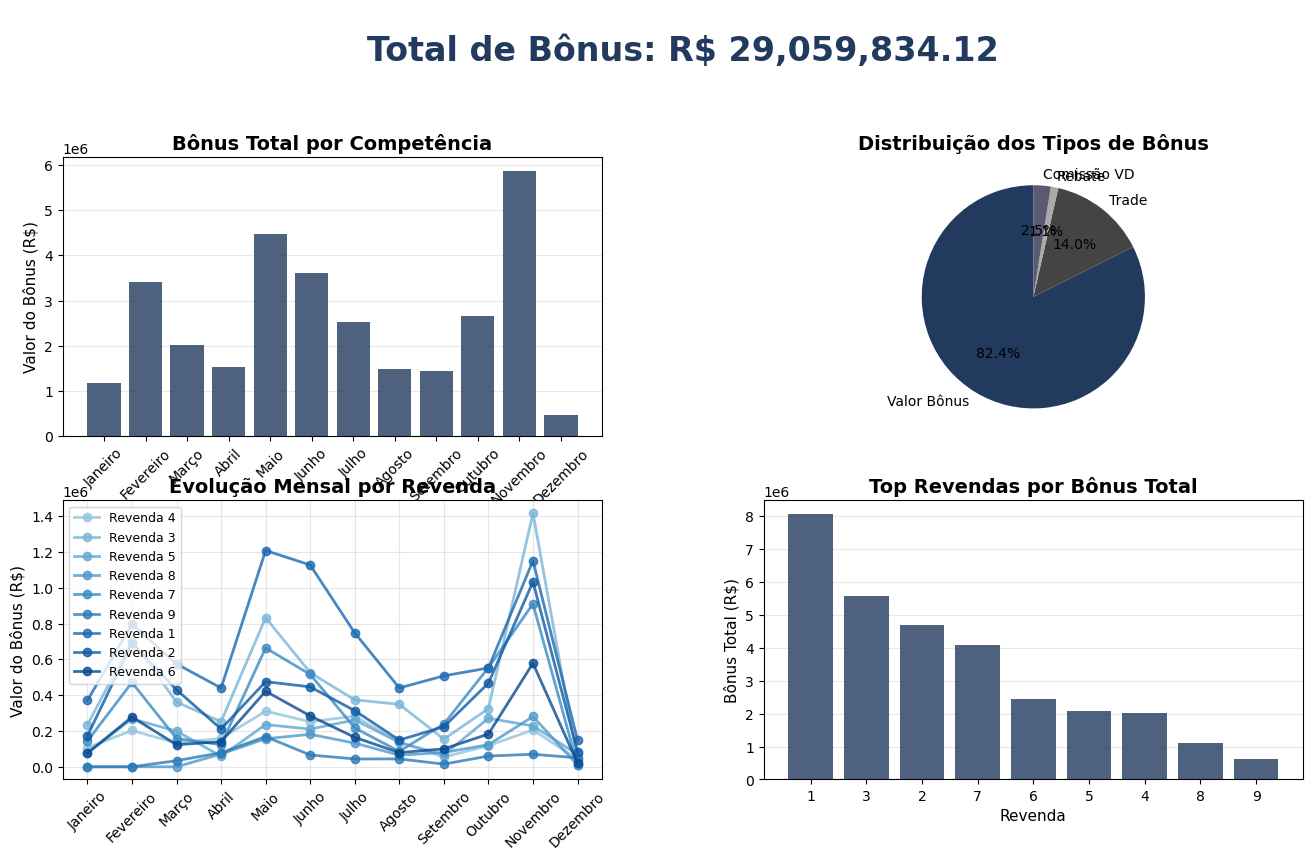

In [34]:
from matplotlib.patches import Wedge
import numpy as np

import matplotlib.pyplot as plt

# Paleta de cores profissionais
azul_marinho = '#223A5E'
cinza = '#A9A9A9'
cinza_escuro = '#444444'

# Filtragem inicial dos dados
data_filtrado = data.copy()

# 1. KPI: Total de bônus por ano
total_bonus_calc = (data_filtrado['valor_bonus'].astype(float).sum() + 
                    data_filtrado['rebate'].astype(float).sum() + 
                    data_filtrado['trade'].astype(float).sum() + 
                    data_filtrado['reembolso_ipva'].astype(float).sum())

# Criar figura com subplots
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, height_ratios=[0.3, 1, 1], hspace=0.3, wspace=0.3)

# 1. KPI no topo
ax_kpi = fig.add_subplot(gs[0, :])
ax_kpi.text(0.5, 0.5, f'Total de Bônus: R$ {total_bonus_calc:,.2f}', 
            ha='center', va='center', fontsize=24, fontweight='bold', 
            color=azul_marinho)
ax_kpi.axis('off')

# 2. Gráfico de barras: Bônus por competência
ax1 = fig.add_subplot(gs[1, 0])
bonus_por_mes_mpl = data_filtrado.groupby('competencia')['bonus_numeric'].sum().reindex(ordem_meses)
ax1.bar(ordem_meses, bonus_por_mes_mpl.values, color=azul_marinho, alpha=0.8)
ax1.set_title("Bônus Total por Competência", fontsize=14, fontweight='bold')
ax1.set_ylabel("Valor do Bônus (R$)", fontsize=11)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)
ax1.set_axisbelow(True)

# 3. Gráfico de pizza: Distribuição de tipos de bônus
ax3 = fig.add_subplot(gs[1, 1])
tipos_mpl = ['valor_bonus', 'trade', 'rebate', 'comissao_vd']
nomes_tipos_mpl = ['Valor Bônus', 'Trade', 'Rebate', 'Comissão VD']
cores_tipos_mpl = [azul_marinho, cinza_escuro, cinza, '#5A5A72']
valores_mpl = [data_filtrado[t].astype(float).sum() for t in tipos_mpl]
total_mpl = sum(valores_mpl)
percentuais_mpl = [(v/total_mpl * 100) if total_mpl > 0 else 0 for v in valores_mpl]

wedges, texts, autotexts = ax3.pie(valores_mpl, labels=nomes_tipos_mpl, colors=cores_tipos_mpl, 
                                     autopct='%1.1f%%', startangle=90, 
                                     textprops={'fontsize': 10})
ax3.set_title("Distribuição dos Tipos de Bônus", fontsize=14, fontweight='bold')

# 4. Gráfico de linhas: Evolução mensal por revenda
ax2 = fig.add_subplot(gs[2, 0])
colors_mpl = plt.cm.Blues(np.linspace(0.4, 0.9, len(revendas)))
for idx, rev in enumerate(revendas):
    serie_mpl = data_filtrado[data_filtrado['revenda'] == rev].groupby('competencia')['bonus_numeric'].sum().reindex(ordem_meses, fill_value=0)
    ax2.plot(ordem_meses, serie_mpl.values, marker='o', linewidth=2, 
             color=colors_mpl[idx], label=f'Revenda {rev}', alpha=0.8)

ax2.set_title("Evolução Mensal por Revenda", fontsize=14, fontweight='bold')
ax2.set_ylabel("Valor do Bônus (R$)", fontsize=11)
ax2.tick_params(axis='x', rotation=45)
ax2.legend(loc='upper left', fontsize=9)
ax2.grid(alpha=0.3)
ax2.set_axisbelow(True)

# 5. Gráfico de barras: Top Revendas por Bônus Total
ax4 = fig.add_subplot(gs[2, 1])
bonus_por_revenda_mpl = data_filtrado.groupby('revenda')['bonus_numeric'].sum().sort_values(ascending=False)
top_revendas_mpl = bonus_por_revenda_mpl.head(9)
ax4.bar([str(r) for r in top_revendas_mpl.index], top_revendas_mpl.values, 
        color=azul_marinho, alpha=0.8)
ax4.set_title("Top Revendas por Bônus Total", fontsize=14, fontweight='bold')
ax4.set_xlabel("Revenda", fontsize=11)
ax4.set_ylabel("Bônus Total (R$)", fontsize=11)
ax4.grid(axis='y', alpha=0.3)
ax4.set_axisbelow(True)

plt.tight_layout()
plt.show()

In [45]:

# Dashboard interativo com Bokeh: KPIs e múltiplos gráficos
from bokeh.layouts import column, row, gridplot
from bokeh.models import Panel, Tabs, Div, HoverTool, Select, CustomJS
from bokeh.palettes import Blues8, Greys8
from bokeh.transform import dodge

# Paleta de cores profissionais
azul_marinho = '#223A5E'
cinza = '#A9A9A9'
cinza_escuro = '#444444'

# Filtro de competência
select_competencia = Select(title="Filtrar por Competência:", 
                            value="Todas", 
                            options=["Todas"] + ordem_meses,
                            width=200)

# Filtragem inicial dos dados
data_filtrado = data.copy()

# 1. KPI: Total de bônus por ano
total_bonus = (data_filtrado['valor_bonus'].astype(float).sum() + 
               data_filtrado['rebate'].astype(float).sum() + 
               data_filtrado['trade'].astype(float).sum() + 
               data_filtrado['reembolso_ipva'].astype(float).sum())
kpi_total = Div(text=f"<h2 style='color:{azul_marinho}'>Total de Bônus: R$ {total_bonus:,.2f}</h2>")

# 2. Gráfico de barras: Bônus por competência (com HoverTool)
bonus_por_mes = data_filtrado.groupby('competencia')['bonus_numeric'].sum().reindex(ordem_meses)
source_p1 = ColumnDataSource(data=dict(
    competencia=ordem_meses,
    bonus=bonus_por_mes.values
))

p1 = bp.figure(x_range=ordem_meses, title="Bônus Total por Competência",
               width=600, height=350, toolbar_location="above",
               background_fill_color='white')
p1.vbar(x='competencia', top='bonus', width=0.7, color=azul_marinho, source=source_p1)
p1.xgrid.grid_line_color = None
p1.yaxis.axis_label = "Valor do Bônus (R$)"
p1.xaxis.major_label_orientation = 45

hover_p1 = HoverTool(tooltips=[
    ("Competência", "@competencia"),
    ("Bônus Total", "R$ @bonus{0,0.00}")
])
p1.add_tools(hover_p1)

# 3. Gráfico de linhas: Evolução mensal por revenda (com HoverTool)
p2 = bp.figure(x_range=ordem_meses, title="Evolução Mensal por Revenda",
               width=600, height=350, toolbar_location="above",
               background_fill_color='white')

for idx, rev in enumerate(revendas):
    serie = data_filtrado[data_filtrado['revenda'] == rev].groupby('competencia')['bonus_numeric'].sum().reindex(ordem_meses, fill_value=0)
    source_rev = ColumnDataSource(data=dict(
        competencia=ordem_meses,
        bonus=serie.values,
        revenda=[f'Revenda {rev}'] * len(ordem_meses)
    ))
    p2.line('competencia', 'bonus', line_width=2, color=Blues8[idx % len(Blues8)], 
            legend_label=str(rev), source=source_rev)
    p2.circle('competencia', 'bonus', size=6, color=Blues8[idx % len(Blues8)], 
              source=source_rev, alpha=0.6)

p2.xaxis.major_label_orientation = 45
p2.yaxis.axis_label = "Valor do Bônus (R$)"
p2.legend.location = "top_left"
p2.legend.label_text_color = azul_marinho

hover_p2 = HoverTool(tooltips=[
    ("Revenda", "@revenda"),
    ("Competência", "@competencia"),
    ("Bônus", "R$ @bonus{0,0.00}")
])
p2.add_tools(hover_p2)

# 4. Gráfico de pizza: Distribuição de tipos de bônus (com HoverTool)
from math import pi

tipos = ['valor_bonus', 'trade', 'rebate', 'comissao_vd']
nomes_tipos = ['Valor Bônus', 'Trade', 'Rebate', 'Comissão VD']
cores_tipos = [azul_marinho, cinza_escuro, cinza, '#5A5A72']
valores = [data_filtrado[t].astype(float).sum() for t in tipos]
total = sum(valores)
percentuais = [(v/total * 100) if total > 0 else 0 for v in valores]

angles = [v/total * 2 * pi if total > 0 else 0 for v in valores]
starts = [0] + list(np.cumsum(angles[:-1]))
ends = list(np.cumsum(angles))

source_p3 = ColumnDataSource(data=dict(
    start=starts,
    end=ends,
    color=cores_tipos,
    nome=nomes_tipos,
    valor=valores,
    percentual=percentuais
))

p3 = bp.figure(title="Distribuição dos Tipos de Bônus", width=400, height=400, 
               toolbar_location="above", background_fill_color='white', 
               x_range=(-1,1), y_range=(-1,1))

p3.wedge(x=0, y=0, radius=0.8, start_angle='start', end_angle='end',
         color='color', legend_field='nome', alpha=0.8, source=source_p3)

p3.axis.visible = False
p3.grid.visible = False
p3.legend.label_text_color = azul_marinho

hover_p3 = HoverTool(tooltips=[
    ("Tipo", "@nome"),
    ("Valor", "R$ @valor{0,0.00}"),
    ("Percentual", "@percentual{0.00}%")
])
p3.add_tools(hover_p3)

# 5. Gráfico de barras: Top Revendas por Bônus Total (com HoverTool)
bonus_por_revenda = data_filtrado.groupby('revenda')['bonus_numeric'].sum().sort_values(ascending=False)
top_revendas = bonus_por_revenda.head(9)

source_p4 = ColumnDataSource(data=dict(
    revenda=[str(r) for r in top_revendas.index],
    bonus=top_revendas.values
))

p4 = bp.figure(x_range=[str(r) for r in top_revendas.index], 
               title="Top Revendas por Bônus Total", 
               width=600, height=350, 
               toolbar_location="above",
               background_fill_color='white')
p4.vbar(x='revenda', top='bonus', width=0.7, color=azul_marinho, 
        alpha=0.8, source=source_p4)
p4.xaxis.axis_label = "Revenda"
p4.yaxis.axis_label = "Bônus Total (R$)"
p4.xgrid.grid_line_color = None

hover_p4 = HoverTool(tooltips=[
    ("Revenda", "@revenda"),
    ("Bônus Total", "R$ @bonus{0,0.00}")
])
p4.add_tools(hover_p4)

# Layout do dashboard
layout = column(
    select_competencia,
    kpi_total,
    row(p1, p3),
    row(p2, p4)
)

bp.show(layout)



KeyError: 'Column not found: bonus_numeric'